In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### Analyze direct QA

In [345]:
def load_qa(filters=None):
    df = pd.read_json("results/qa_results.jsonl", lines=True)
    
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['config_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)

    df['options_str'] = df['options'].apply(str)

    df = df.sort_values('datetime', ascending=False).drop_duplicates(
        subset=['question', 'options_str', 'config_model_name'], keep='first')

    df['parsed_answer'] = df['parsed_model_response'].apply(lambda x: x.get('answer'))
    df = df[df['parsed_answer'].notna()]

    df['is_correct'] = df['parsed_answer'] == df['correct_idx']
    
    if filters:
        for col, val in filters.items():
            if val is None:
                df = df[df[col].isna()]
            else:
                df = df[df[col] == val]
    
    return df

In [346]:
filters = {
    # MODEL OPTIONS
    'config_model_name': "x-ai/grok-4-fast",
    # 'config_model_name': "openai/gpt-4o-mini",

    # DATASET OPTIONS
    # 'config_dataset_name': "Idavidrein/gpqa",
    # 'config_dataset_subset': "gpqa_diamond",
    # 'config_dataset_split': "train",

    'config_dataset_name': "TIGER-Lab/MMLU-Pro",
    'config_dataset_subset': None,
    'config_dataset_split': "test",

    # OTHER OPTIONS
    'config_random_seed': 42,
    'config_num_choices': 4,
}


In [347]:
df = load_qa(filters)

valid_df = df[df['parsed_answer'].notna()]
accuracy = valid_df['is_correct'].mean()
correct_count = valid_df['is_correct'].sum()
total_count = len(valid_df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 92.00%
Correct: 92/100


### Analyze debate

In [348]:
def load_debate(debate_run_id):
    df = pd.read_json(f"results/debate/{debate_run_id}.jsonl", lines=True)
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['debate_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)
    df['options_str'] = df['options'].apply(str)
    return df

def load_verdict(verdict_run_id):
    df = pd.read_json(f"results/verdicts/{verdict_run_id}.jsonl", lines=True)
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['verdict_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)
    return df

def load_debate_and_verdict(verdict_run_id):
    verdict_df = load_verdict(verdict_run_id)
    debate_run_id = verdict_df['debate_run_id'].iloc[0]
    debate_df = load_debate(debate_run_id)
    
    df = debate_df.merge(verdict_df[['record_id', 'judge_verdict', 'verdict_judge_model']], on='record_id')
    df['parsed_answer'] = df['judge_verdict'].apply(lambda x: x.get('parsed', {}).get('answer'))
    df = df[df['parsed_answer'].notna()]
    df['is_correct_verdict'] = df['parsed_answer'] == df['correct_idx']
    
    return df

In [349]:
# run_id = 'ey2anfr'
run_id = 'hkpd1jy'

df = load_debate_and_verdict(run_id)

valid_df = df[df['parsed_answer'].notna()]
accuracy = valid_df['is_correct_verdict'].mean()
correct_count = valid_df['is_correct_verdict'].sum()
total_count = len(valid_df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 87.50%
Correct: 14/16


### Compare QA and Debate

In [350]:
def load_debate_and_verdict_and_qa(verdict_run_id):
    df = load_debate_and_verdict(verdict_run_id)
    
    qa_df = load_qa(filters=None)
    qa_df = qa_df[['question', 'options_str', 'config_model_name', 'is_correct']]
    
    judge_qa = qa_df.rename(columns={'is_correct': 'is_correct_judge_qa'})
    df = df.merge(judge_qa, left_on=['question', 'options_str', 'verdict_judge_model'], 
                  right_on=['question', 'options_str', 'config_model_name'], how='left')
    
    debater_qa = qa_df.rename(columns={'is_correct': 'is_correct_debater_qa'})
    df = df.merge(debater_qa, left_on=['question', 'options_str', 'debate_debater_model'], 
                  right_on=['question', 'options_str', 'config_model_name'], how='left')
    
    df = df[df['is_correct_verdict'].notna() & df['is_correct_judge_qa'].notna() & df['is_correct_debater_qa'].notna()]
    
    return df

In [351]:
verdict_run_id = 'hkpd1jy'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)

judge_qa = merged_df["is_correct_judge_qa"].mean().round(2) 
debater_qa = merged_df["is_correct_debater_qa"].mean().round(2)
debate_verdict = merged_df["is_correct_verdict"].mean().round(2)

print(f'Judge QA: {judge_qa} ({merged_df["is_correct_judge_qa"].sum()}/{merged_df["is_correct_judge_qa"].count()})')
print(f'Debater QA: {debater_qa} ({merged_df["is_correct_debater_qa"].sum()}/{merged_df["is_correct_debater_qa"].count()})')
print(f'Debate Verdict: {debate_verdict} ({merged_df["is_correct_verdict"].sum()}/{merged_df["is_correct_verdict"].count()})')

Judge QA: 0.75 (12/16)
Debater QA: 1.0 (16/16)
Debate Verdict: 0.88 (14/16)


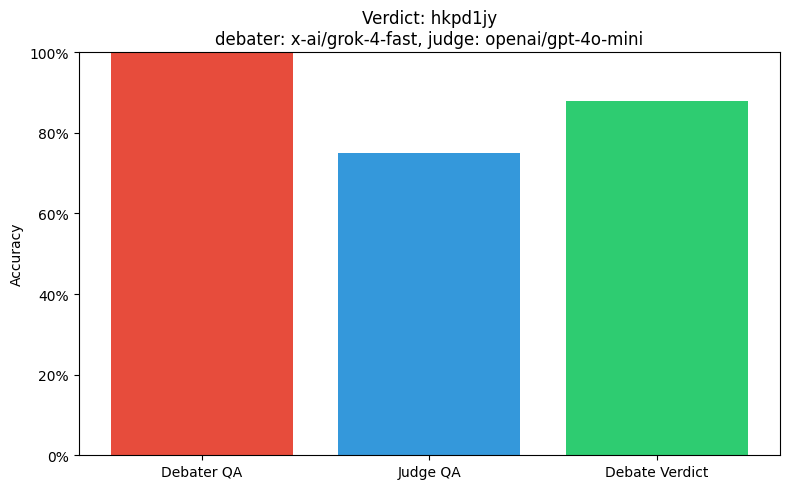

In [352]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
debater_model = merged_df['debate_debater_model'].iloc[0]
judge_model = merged_df['verdict_judge_model'].iloc[0]
plt.title(f'Verdict: {verdict_run_id}\ndebater: {debater_model}, judge: {judge_model}')
plt.tight_layout()
plt.show()

### Analyze token usage in the debate run

In [353]:
run_id = 'dcg8y0b'

debate_df = load_debate(run_id)

record_ids = []
completion_tokens_used_per_debate = []
reasoning_tokens_used_per_debate = []
for i, row in debate_df.iterrows():
    record_ids.append(row['record_id'])
    debate_history = row['debate_history']
    completion_tokens_used_this_debate, reasoning_tokens_used_this_debate = 0, 0
    for turn in debate_history:
        completion_tokens_used_this_debate += turn['token_usage']['completion_tokens']
        if 'completion_tokens_details' in turn['token_usage'] and turn['token_usage']['completion_tokens_details'] is not None:
            reasoning_tokens_used_this_debate += turn['token_usage']['completion_tokens_details']['reasoning_tokens']
        else:
            reasoning_tokens_used_this_debate += 0
    completion_tokens_used_per_debate.append(completion_tokens_used_this_debate)
    reasoning_tokens_used_per_debate.append(reasoning_tokens_used_this_debate)

print(record_ids)
print(f"completion_tokens_used_per_debate: {completion_tokens_used_per_debate}")
print(f"reasoning_tokens_used_per_debate: {reasoning_tokens_used_per_debate}")


['uopkylg', '0g649bb', 'dn0srf9', 'pvy2pz2', 'z6cpl1k', 'fhpjpo6', 'ug10m7x', 'i4kch6d', 'dezmdd2', 'jw0dpuy', 'qs23z34', 'uy2xyzr', 'sq9cqvp', 'cgttxpu', 'ftrrg0m', 'os7f0j8']
completion_tokens_used_per_debate: [2449, 2630, 2459, 2581, 2982, 3107, 3925, 2791, 5296, 8696, 13599, 14033, 17834, 18264, 20398, 15979]
reasoning_tokens_used_per_debate: [1385, 1538, 1373, 1445, 1919, 1937, 2696, 1701, 3874, 7343, 12072, 12755, 16497, 16887, 18834, 15049]


In [354]:
import numpy as np
print(np.sum(completion_tokens_used_per_debate))
print(np.sum(reasoning_tokens_used_per_debate))


137023
117305
